In [105]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import joblib
import warnings
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [54]:
warnings.simplefilter('ignore')


In [55]:
df = pd.read_csv('thyroid_cancer_risk_data.csv')
df.drop(columns=['Patient_ID', 'Age', 'Country', 'Ethnicity'], axis=1, inplace=True)
df.head()

,Gender,Family_History,Radiation_Exposure,Iodine_Deficiency,Smoking,Obesity,Diabetes,TSH_Level,T3_Level,T4_Level,Nodule_Size,Thyroid_Cancer_Risk,Diagnosis
0,Male,No,Yes,No,No,No,No,9.37,1.67,6.16,1.08,Low,Benign
1,Male,No,Yes,No,No,No,No,1.83,1.73,10.54,4.05,Low,Benign
2,Male,No,No,No,No,No,No,6.26,2.59,10.57,4.61,Low,Benign
3,Female,No,No,No,No,No,No,4.10,2.62,11.04,2.46,Medium,Benign
4,Female,Yes,Yes,No,No,No,No,9.10,2.11,10.71,2.11,High,Benign


In [56]:
ohe_encoding = OneHotEncoder(sparse_output=False)
encoded_cols = ["Gender"]
df_ohe_encoding = pd.DataFrame(ohe_encoding.fit_transform(df[encoded_cols]), columns=ohe_encoding.get_feature_names_out(encoded_cols))

In [57]:
ord_encoding = OrdinalEncoder(categories=[['Low', 'Medium', 'High']])
df['Thyroid_Cancer_Risk'] = ord_encoding.fit_transform(df[['Thyroid_Cancer_Risk']])

df = df.drop(columns=encoded_cols).join(df_ohe_encoding)

df['Diagnosis'] = df['Diagnosis'].map({'Benign' : 0, 'Malignant' : 1})

In [58]:
binary_cols = ['Family_History', 'Radiation_Exposure', 'Iodine_Deficiency', 'Smoking', 'Obesity', 'Diabetes']
df[binary_cols] = df[binary_cols].replace({'Yes' : 1, 'No' : 0}).astype(int)

In [59]:
df

,Family_History,Radiation_Exposure,Iodine_Deficiency,Smoking,Obesity,Diabetes,TSH_Level,T3_Level,T4_Level,Nodule_Size,Thyroid_Cancer_Risk,Diagnosis,Gender_Female,Gender_Male
0,0,1,0,0,0,0,9.37,1.67,6.16,1.08,0.0,0,0.0,1.0
1,0,1,0,0,0,0,1.83,1.73,10.54,4.05,0.0,0,0.0,1.0
2,0,0,0,0,0,0,6.26,2.59,10.57,4.61,0.0,0,0.0,1.0
3,0,0,0,0,0,0,4.10,2.62,11.04,2.46,1.0,0,1.0,0.0
4,1,1,0,0,0,0,9.10,2.11,10.71,2.11,2.0,0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212686,0,0,0,0,1,0,2.00,0.64,11.92,1.48,0.0,0,1.0,0.0
212687,0,0,0,0,1,0,9.77,3.25,7.30,4.46,1.0,0,0.0,1.0
212688,0,0,0,0,0,1,7.72,2.44,8.71,2.36,1.0,0,1.0,0.0
212689,0,0,0,0,0,1,5.62,2.53,9.62,1.54,1.0,0,1.0,0.0


## Train test & split

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

df_resultats = pd.DataFrame()


X = df.drop(columns='Diagnosis')
y = df['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## train test split smote 

In [ ]:
smote = SMOTE(sampling_strategy="auto", random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

### test logistic classification

In [88]:
# print(f'Len x_train = {len(X_train)}')
# print(f'Len x_test = {len(X_test)}')
# print(f'Len y_train = {len(y_train)}')
# print(f'Len y_test = {len(y_test)}')


## Logistic regression

In [70]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(random_state=42, n_jobs=-1)

score = cross_val_score(model_lr, X, y, cv=5)
print(f'Score des validations croisées {score}')
print(f'Score moyen : {score.mean()}')

df_resultats['lr_score'] = score

Score des validations croisées [0.826089   0.82824768 0.82709577 0.82850628 0.82683718]
Score moyen : 0.8273551831820928


In [71]:
clf_lr = GridSearchCV(estimator=LogisticRegression(), cv=5, param_grid={'max_iter' :[100,200,500], 'C' : [0.01, 0.1, 1, 10, 100]},scoring='roc_auc', verbose=1, n_jobs=-1)

clf_lr.fit(X_train, y_train)

print(f'Meilleurs paramètres : {clf_lr.best_params_}')
print(f'Meilleur score AUC : {clf_lr.best_score_}')
print(f'Meilleur estimateur : {clf_lr.best_estimator_}')

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Meilleurs paramètres : {'C': 100, 'max_iter': 100}
Meilleur score AUC : 0.6973052132690352
Meilleur estimateur : LogisticRegression(C=100)


In [37]:
# joblib.dump(clf_lr.best_estimator_, 'pred_cancer_logistic_regression.joblib')
# print("Model save sous 'pred_cancer_logistic_regression.pkl'")

Accuracy : 0.8260838592941914
AUC : 0.6956947037876624


Classification report : 
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     53887
           1       0.69      0.45      0.55     16302

    accuracy                           0.83     70189
   macro avg       0.77      0.69      0.72     70189
weighted avg       0.81      0.83      0.81     70189

Matrice de confusion


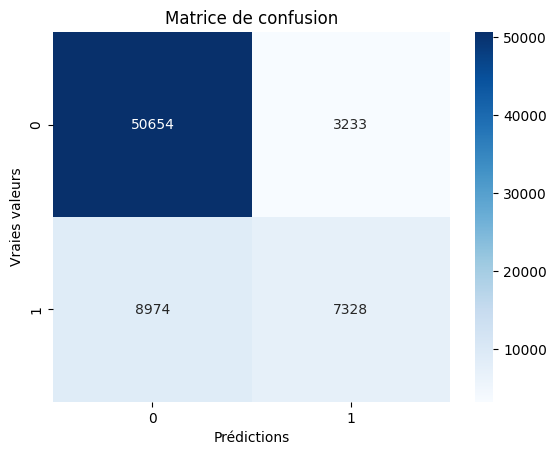

Matrice de confusion : 
[[50654  3233]
 [ 8974  7328]]


In [72]:
best_lr_model = clf_lr.best_estimator_
y_pred = best_lr_model.predict(X_test)
y_proba = best_lr_model.predict_proba(X_test)[:,1]


print(f'Accuracy : {accuracy_score(y_test, y_pred)}')

print(f'AUC : {roc_auc_score(y_test, y_proba)}')

print(f'\n\nClassification report : \n{classification_report(y_test, y_pred)}')

print(f'Matrice de confusion')


confusion_matrix_graph = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix_graph, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de confusion")
plt.show()
print(f'Matrice de confusion : \n{confusion_matrix(y_test, y_pred)}')

## Random Forest regression

In [144]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced', n_jobs=-1)

score = cross_val_score(model_rf, X, y, cv=5)
print(f'Score des validations croisées {score}')
print(f'Score moyen : {score.mean()}')

Score des validations croisées [0.82199864 0.82364004 0.82326391 0.82401617 0.82309935]
Score moyen : 0.8232036202988547


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': [10, 20, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

clf_rf_randomized = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
    param_distributions=param_dist,
    n_iter=20, 
    cv=5, 
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

clf_rf_randomized.fit(X_train, y_train)
print(f'Meilleurs paramètres : {clf_rf_randomized.best_params_}')
print(f'Meilleur score AUC : {clf_rf_randomized.best_score_}')
print(f'Meilleur estimateur : {clf_rf_randomized.best_estimator_}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Meilleurs paramètres : {'bootstrap': False, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 51}
Meilleur score AUC : 0.6981523924500899
Meilleur estimateur : RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=10,
                       max_features='log2', min_samples_leaf=8,
                       min_samples_split=5, n_estimators=51, n_jobs=-1,
                       random_state=42)


Accuracy : 0.8260696120474719
AUC : 0.694750461074826


Classification report : 
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     53887
           1       0.69      0.45      0.55     16302

    accuracy                           0.83     70189
   macro avg       0.77      0.69      0.72     70189
weighted avg       0.81      0.83      0.81     70189

Matrice de confusion : 
[[50653  3234]
 [ 8974  7328]]
Matrice de confusion


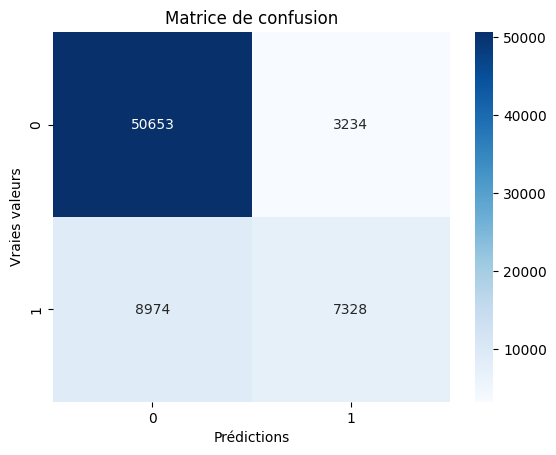

In [149]:
model_rf_randomized = clf_rf_randomized.best_estimator_

y_pred_rf_randomized = model_rf_randomized.predict(X_test)

print(f'Accuracy : {accuracy_score(y_test, y_pred_rf_randomized)}')
print(f'AUC : {roc_auc_score(y_test, y_pred_rf_randomized)}')
print(f'\n\nClassification report : \n{classification_report(y_test, y_pred_rf_randomized)}')
print(f'Matrice de confusion : \n{confusion_matrix(y_test, y_pred_rf_randomized)}')

print(f'Matrice de confusion')
confusion_matrix_graph = confusion_matrix(y_test, y_pred_rf_randomized)
sns.heatmap(confusion_matrix_graph, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de confusion")
plt.show()

## Decision Tree

In [97]:
from sklearn.tree import DecisionTreeClassifier

model_decision_tree = DecisionTreeClassifier(random_state=42)

score = cross_val_score(model_decision_tree, X, y, cv=5)
print(f'Score des validations croisées {score}')
print(f'Score moyen : {score.mean()}')

df_resultats['decision_tree'] = score

Score des validations croisées [0.70321352 0.70797875 0.70506371 0.70713245 0.70506371]
Score moyen : 0.7056904263786652


In [98]:
clf_decision_tree = GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), param_grid={'max_depth' :[1,2,3,4,5,6,7,8,9,10], 'criterion' : ['gini', 'entropy']},scoring='roc_auc', verbose=1, n_jobs=-1)
clf_decision_tree.fit(X_train, y_train)

print(f'Meilleurs paramètres : {clf_decision_tree.best_params_}')
print(f'Meilleur score AUC : {clf_decision_tree.best_score_}')
print(f'Meilleur estimateur : {clf_decision_tree.best_estimator_}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Meilleurs paramètres : {'criterion': 'entropy', 'max_depth': 2}
Meilleur score AUC : 0.6992229762040398
Meilleur estimateur : DecisionTreeClassifier(criterion='entropy', max_depth=2)


In [99]:
# joblib.dump(clf_decision_tree.best_estimator_, 'pred_cancer_decision_tree.joblib')
# print("Model save sous 'pred_cancer_decision_tree.pkl'")

Accuracy : 0.8260838592941914
AUC : 0.6947597397505734


Classification report : 
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     53887
           1       0.69      0.45      0.55     16302

    accuracy                           0.83     70189
   macro avg       0.77      0.69      0.72     70189
weighted avg       0.81      0.83      0.81     70189

Matrice de confusion : 
[[50654  3233]
 [ 8974  7328]]
Matrice de confusion


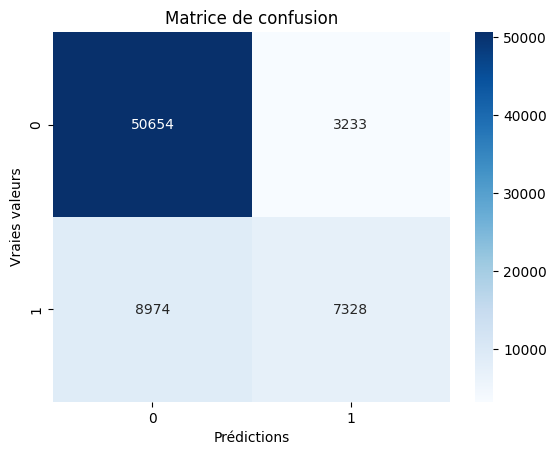

In [100]:
model_decision_tree = clf_decision_tree.best_estimator_

y_pred_decision_tree = model_decision_tree.predict(X_test)

print(f'Accuracy : {accuracy_score(y_test, y_pred_decision_tree)}')
print(f'AUC : {roc_auc_score(y_test, y_pred_decision_tree)}')
print(f'\n\nClassification report : \n{classification_report(y_test, y_pred_decision_tree)}')
print(f'Matrice de confusion : \n{confusion_matrix(y_test, y_pred_decision_tree)}')

print(f'Matrice de confusion')

confusion_matrix_graph = confusion_matrix(y_test, y_pred_decision_tree)

sns.heatmap(confusion_matrix_graph, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de confusion")
plt.show()

# Avec smote

## train test split 

In [89]:
smote = SMOTE(sampling_strategy="auto", random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

## Decison tree

In [101]:
model_decision_tree_smote = DecisionTreeClassifier(random_state=42)

score = cross_val_score(model_decision_tree_smote, X_resampled, y_resampled, cv=5)
print(f'Score des validations croisées {score}')
print(f'Score moyen : {score.mean()}')

df_resultats['decision_tree_smote'] = score

Score des validations croisées [0.69183972 0.71949044 0.75441405 0.74907943 0.75184685]
Score moyen : 0.7333340999281217


In [102]:
clf_decision_tree_smote = GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), param_grid={'max_depth' :[1,2,3,4,5,6,7,8,9,10], 'criterion' : ['gini', 'entropy']},scoring='roc_auc', verbose=1, n_jobs=-1)
clf_decision_tree_smote.fit(X_resampled, y_resampled)

print(f'Meilleurs paramètres : {clf_decision_tree_smote.best_params_}')
print(f'Meilleur score AUC : {clf_decision_tree_smote.best_score_}')
print(f'Meilleur estimateur : {clf_decision_tree_smote.best_estimator_}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Meilleurs paramètres : {'criterion': 'gini', 'max_depth': 10}
Meilleur score AUC : 0.7640295364287173
Meilleur estimateur : DecisionTreeClassifier(max_depth=10)


Accuracy : 0.8220518884725527
AUC : 0.6908075452456336


Classification report : 
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     53887
           1       0.68      0.45      0.54     16302

    accuracy                           0.82     70189
   macro avg       0.76      0.69      0.71     70189
weighted avg       0.81      0.82      0.81     70189

Matrice de confusion : 
[[50433  3454]
 [ 9036  7266]]
Matrice de confusion


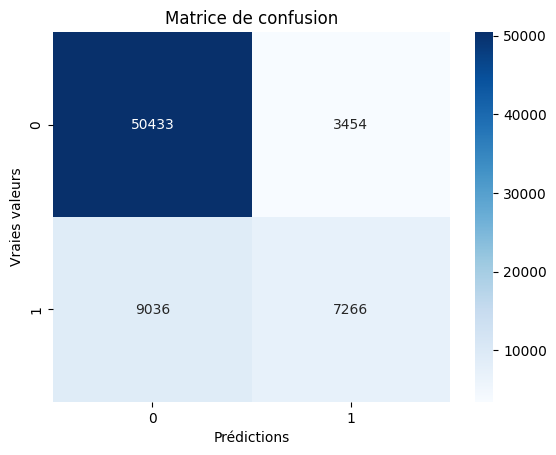

In [103]:
model_decision_tree_smote = clf_decision_tree_smote.best_estimator_
y_pred_decision_tree_smote = model_decision_tree_smote.predict(X_test)

print(f'Accuracy : {accuracy_score(y_test, y_pred_decision_tree_smote)}')
print(f'AUC : {roc_auc_score(y_test, y_pred_decision_tree_smote)}')
print(f'\n\nClassification report : \n{classification_report(y_test, y_pred_decision_tree_smote)}')
print(f'Matrice de confusion : \n{confusion_matrix(y_test, y_pred_decision_tree_smote)}')

print(f'Matrice de confusion')
confusion_matrix_graph = confusion_matrix(y_test, y_pred_decision_tree_smote)
sns.heatmap(confusion_matrix_graph, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de confusion")
plt.show()


## LightGBM

In [ ]:
model_lgbm = lgb.LGBMClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

score = cross_val_score(model_lgbm, X_resampled, y_resampled, cv=5)
print(f'Score des validations croisées {score}')
print(f'Score moyen : {score.mean()}')
df_resultats['lightgbm_smote'] = score

[LightGBM] [Info] Number of positive: 87447, number of negative: 87447
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1417
[LightGBM] [Info] Number of data points in the train set: 174894, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 87447, number of negative: 87447
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1399
[LightGBM] [Info] Number of data points in the train set: 174894, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0

In [83]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'num_leaves': randint(20, 150),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(50, 500),
    'min_child_samples': randint(5, 50),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'reg_lambda': uniform(0, 10),
    'reg_alpha': uniform(0, 10)
}

clf_lgb = RandomizedSearchCV(
    lgb.LGBMClassifier(),
    param_distributions=param_dist,
    n_iter=20, 
    cv=5, 
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

clf_lgb.fit(X_resampled, y_resampled)

print(f'Meilleurs paramètres : {clf_lgb.best_params_}')
print(f'Meilleur score AUC : {clf_lgb.best_score_}')
print(f'Meilleur estimateur : {clf_lgb.best_estimator_}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Number of positive: 109309, number of negative: 109309
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1405
[LightGBM] [Info] Number of data points in the train set: 218618, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Meilleurs paramètres : {'colsample_bytree': np.float64(0.

Accuracy : 0.7827864765134138
AUC : 0.6808519724011498


Classification report : 
              precision    recall  f1-score   support

           0       0.85      0.87      0.86     53887
           1       0.54      0.49      0.51     16302

    accuracy                           0.78     70189
   macro avg       0.69      0.68      0.69     70189
weighted avg       0.78      0.78      0.78     70189

Matrice de confusion : 
[[46947  6940]
 [ 8306  7996]]
Matrice de confusion


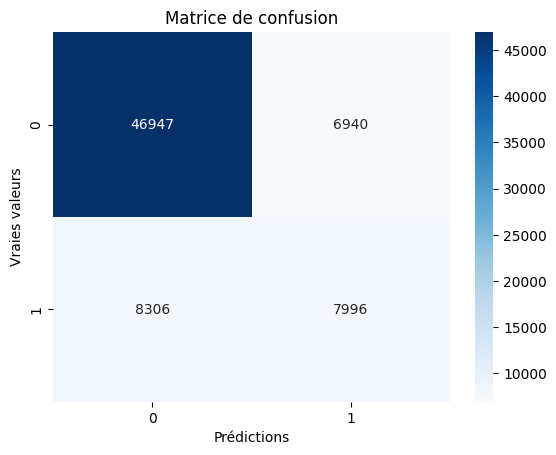

In [ ]:
model_lgbm = clf_lgb.best_estimator_
y_pred_lgbm = model_lgbm.predict(X_test)

print(f'Accuracy : {accuracy_score(y_test, y_pred_lgbm)}')
print(f'AUC : {roc_auc_score(y_test, y_pred_lgbm)}')
print(f'\n\nClassification report : \n{classification_report(y_test, y_pred_lgbm)}')
print(f'Matrice de confusion : \n{confusion_matrix(y_test, y_pred_lgbm)}')

print(f'Matrice de confusion')
confusion_matrix_graph = confusion_matrix(y_test, y_pred_lgbm)
sns.heatmap(confusion_matrix_graph, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de confusion")
plt.show()

In [ ]:
# joblib.dump(clf_lgb.best_estimator_, 'pred_cancer_light_gbm.joblib')
# print("Model save sous 'pred_cancer_light_gbm.pkl'")

Model save sous 'pred_cancer_light_gbm.pkl'


## random forest smote

In [ ]:
model_rf_smote = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
score = cross_val_score(model_rf_smote, X_resampled, y_resampled, cv=5)
print(f'Score des validations croisées {score}')
print(f'Score moyen : {score.mean()}')
df_resultats['random_forest_smote'] = score

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': [10, 20, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

clf_rf_smote = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_distributions=param_dist,
    n_iter=20, 
    cv=5, 
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

clf_rf_smote.fit(X_train, y_train)
print(f'Meilleurs paramètres : {clf_rf_smote.best_params_}')
print(f'Meilleur score AUC : {clf_rf_smote.best_score_}')
print(f'Meilleur estimateur : {clf_rf_smote.best_estimator_}')

In [ ]:
model_rf_smote = clf_rf_smote.best_estimator_

y_pred_rf_smote = model_rf_smote.predict(X_test)

print(f'Accuracy : {accuracy_score(y_test, y_pred_rf_smote)}')
print(f'AUC : {roc_auc_score(y_test, y_pred_rf_smote)}')
print(f'\n\nClassification report : \n{classification_report(y_test, y_pred_rf_smote)}')
print(f'Matrice de confusion : \n{confusion_matrix(y_test, y_pred_rf_smote)}')

print(f'Matrice de confusion')
confusion_matrix_graph = confusion_matrix(y_test, y_pred_rf_smote)
sns.heatmap(confusion_matrix_graph, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de confusion")
plt.show()

## XGBoost

In [115]:
model_xgb_smote = xgb.XGBClassifier(random_state=42, scale_pos_weight=2, n_jobs=-1)

score = cross_val_score(model_xgb_smote, X_resampled, y_resampled, cv=5)
print(f'Score des validations croisées {score}')
print(f'Score moyen : {score.mean()}')
df_resultats['xgboost_smote'] = score

Score des validations croisées [0.62377642 0.65867716 0.68827189 0.68661803 0.69064337]
Score moyen : 0.6695973710611819


In [116]:
params = {
    "n_estimators": [200, 300, 500],  # Plus d'arbres
    "learning_rate": [0.01, 0.05, 0.1, 0.2],  # Taux d'apprentissage plus précis
    "max_depth": [3, 4, 5, 6],  # Contrôle de la complexité
    "subsample": [0.7, 0.8, 1],  # Évite le sur-apprentissage
    "colsample_bytree": [0.6, 0.8, 1],  # Sélection des features
    "lambda": [0, 1, 10],  # Régularisation L2
    "alpha": [0, 1, 10],  # Régularisation L1
    "gamma": [0, 0.1, 0.5, 1]  # Réduction des splits inutiles
}

clf_xgboost_smote = GridSearchCV(
    xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    param_grid=params,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

clf_xgboost_smote.fit(X_resampled, y_resampled)

print(f'Meilleurs paramètres : {clf_xgboost_smote.best_params_}')
print(f'Meilleur score AUC : {clf_xgboost_smote.best_score_}')
print(f'Meilleur estimateur : {clf_xgboost_smote.best_estimator_}')


KeyboardInterrupt: 

In [ ]:
model_xgb_smote = clf_xgboost_smote.best_estimator_
y_pred_xgb_smote = model_xgb_smote.predict(X_test)

print(f'Accuracy : {accuracy_score(y_test, y_pred_xgb_smote)}')
print(f'AUC : {roc_auc_score(y_test, y_pred_xgb_smote)}')
print(f'\n\nClassification report : \n{classification_report(y_test, y_pred_xgb_smote)}')
print(f'Matrice de confusion : \n{confusion_matrix(y_test, y_pred_xgb_smote)}')

Accuracy : 0.762598127911781
AUC : 0.6709129500003777


Classification report : 
              precision    recall  f1-score   support

           0       0.85      0.84      0.84     53887
           1       0.49      0.50      0.49     16302

    accuracy                           0.76     70189
   macro avg       0.67      0.67      0.67     70189
weighted avg       0.76      0.76      0.76     70189

Matrice de confusion : 
[[45380  8507]
 [ 8156  8146]]


# Print des différents test sous forme de graph

In [ ]:
# Calcul de la moyenne des performances pour chaque modèle
mean_results = df_resultats.mean()

# Affichage des résultats triés par performance décroissante
mean_results = mean_results.sort_values(ascending=False)

print("Moyenne des scores pour chaque modèle :")
print(mean_results)

# Optionnel : affichage sous forme de graphique
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
mean_results.plot(kind='bar', color=['blue', 'green', 'red', 'purple'])
plt.xlabel("Modèles")
plt.ylabel("Score moyen")
plt.title("Comparaison des modèles")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()